## **Midterm - EENG 860 -- Sleep Quality Modeling**

### **About Dataset**

Sleep dataset from SC Sleep-EDF Database that is freely available through Physionet at “https://physionet.org/physiobank/ database /sleep-edfx/” for training and evaluation purposes.

15 features were extracted from the brain signals of 8 subjects along with the sleep category

+ SC1 includes the values of the features for the light sleep + REM category 
+ SC2 includes the values of the features for the deep sleep category 
+ SC3 includes the values of the features for the awake category 
+ SC1-label includes the labels for the light sleep + REM category  
+ SC2-label includes the labels for the deep sleep category 
+ SC3-label includes the labels for the awake category 

The number of data for each sleep category is 800. So the available data in each category is 800
by 15. (800 observations, 15 features)

The plan is to compare the performance of the 6 different classifiers: Naïve Base, Decision Tree, Random Forest, Linear discriminate analysis, Quadratic discriminate analysis, and Multilayer Perceptron using 10-fold cross-validation starting from having only one feature and increasing the number of features to two (the first two features), then three (the first three features), then four (the first four features),.... until all 15 features are used.

## **Data & Dependencies**

In [1]:
# Required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go

# Ignore Warnings
import warnings
warnings.filterwarnings('ignore')

# Display settings
pd.options.display.max_rows = 100
pd.options.display.max_columns = 100

In [2]:
# Data Load

# Load data and labels for each category
df_light = pd.read_csv('SC1.txt', sep=',', header = None)
df_deep = pd.read_csv('SC2.txt', sep=',', header = None)
df_awake = pd.read_csv('SC3.txt', sep=',', header = None)

labels_light = pd.read_csv('SC1-label.txt', sep=',', header = None)
labels_deep = pd.read_csv('SC2-label.txt', sep=',', header = None)
labels_awake = pd.read_csv('SC3-label.txt', sep=',', header = None)

# Combine data and labels
df_light['label'] = labels_light
df_deep['label'] = labels_deep
df_awake['label'] = labels_awake

# Combine data from all categories
df_all = pd.concat([df_light, df_deep, df_awake], axis = 0, ignore_index = True)

In [3]:
# Check info

df_all.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2400 entries, 0 to 2399
Data columns (total 16 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   0       2400 non-null   float64
 1   1       2400 non-null   float64
 2   2       2400 non-null   float64
 3   3       2400 non-null   float64
 4   4       2400 non-null   float64
 5   5       2400 non-null   float64
 6   6       2400 non-null   float64
 7   7       2400 non-null   float64
 8   8       2400 non-null   float64
 9   9       2400 non-null   float64
 10  10      2400 non-null   float64
 11  11      2400 non-null   float64
 12  12      2400 non-null   float64
 13  13      2400 non-null   float64
 14  14      2400 non-null   float64
 15  label   2400 non-null   int64  
dtypes: float64(15), int64(1)
memory usage: 300.1 KB


## **Exploratory Data Analysis**

### **Skewness Detection**

In [4]:
# Check for skewed features to plot them

skewed_features = []

for i in df_all.columns:
    if abs(df_all[i].skew()) >=2:
        skewed_features.append(i)
        
skewed_features

[]

Looks like there are no skewed features

In [5]:
df_all.skew()

0        1.107221
1        0.248197
2       -0.272339
3        0.761635
4       -0.201076
5        0.656134
6        0.961859
7       -0.223630
8       -0.603228
9        0.722334
10       0.761556
11       1.256262
12       0.567145
13      -0.238657
14       1.460449
label    0.000000
dtype: float64

Text(0.5, 0, 'Feature 14')

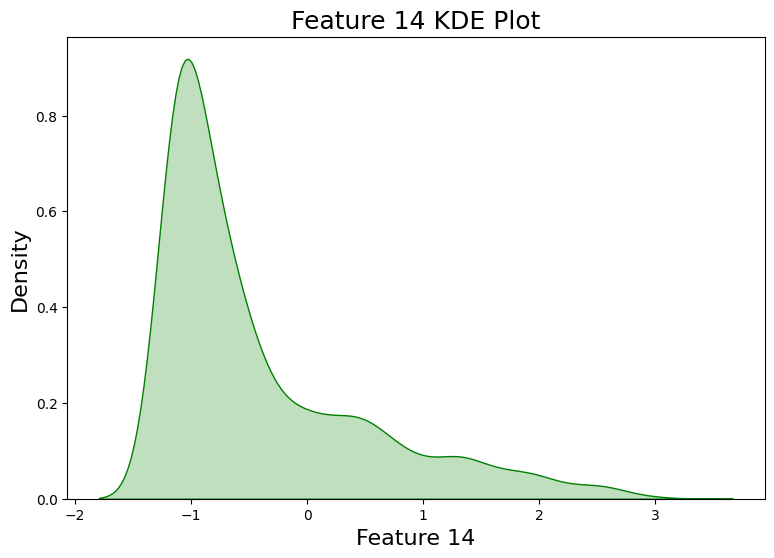

In [6]:
# Plot of feature 14

plt.figure(figsize = (9, 6))
sns.kdeplot(data = df_all, x = 14, color = 'g', shade = True)
plt.title('Feature 14 KDE Plot', fontdict = {'fontsize' : 18, 'fontweight': 18})
plt.ylabel('Density', fontdict = {'fontsize' : 16, 'fontweight': 16})
plt.xlabel('Feature 14', fontdict = {'fontsize' : 16, 'fontweight': 16})

Text(0.5, 0, 'Feature 0')

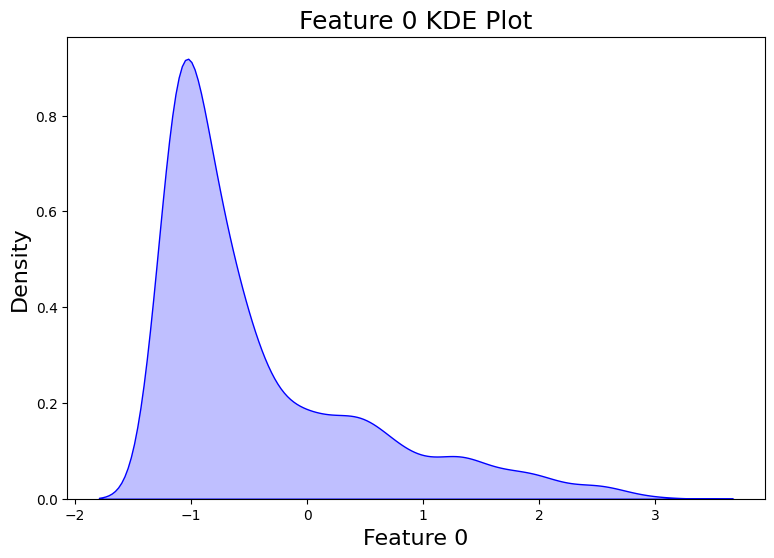

In [7]:
# Plot of feature 0

plt.figure(figsize = (9, 6))
sns.kdeplot(data = df_all, x = 14, color = 'b', shade = True)
plt.title('Feature 0 KDE Plot', fontdict = {'fontsize' : 18, 'fontweight': 18})
plt.ylabel('Density', fontdict = {'fontsize' : 16, 'fontweight': 16})
plt.xlabel('Feature 0', fontdict = {'fontsize' : 16, 'fontweight': 16})

### **Outlier Detection**

Columns with outlier values:
Index([0, 6, 8, 9, 11, 12, 14], dtype='object')


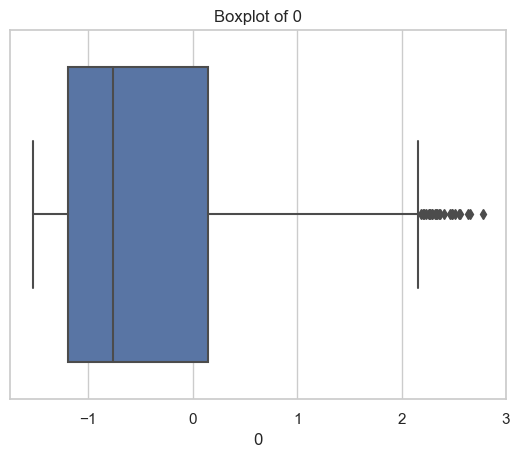

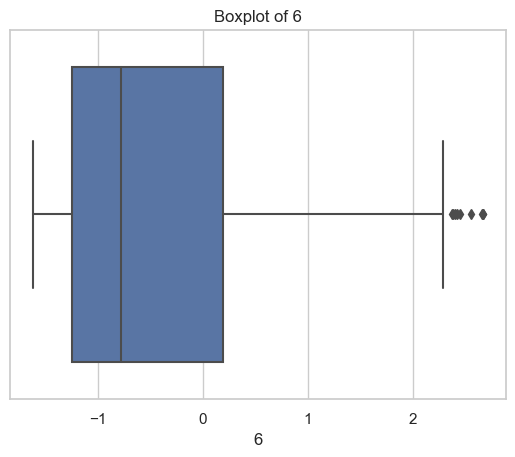

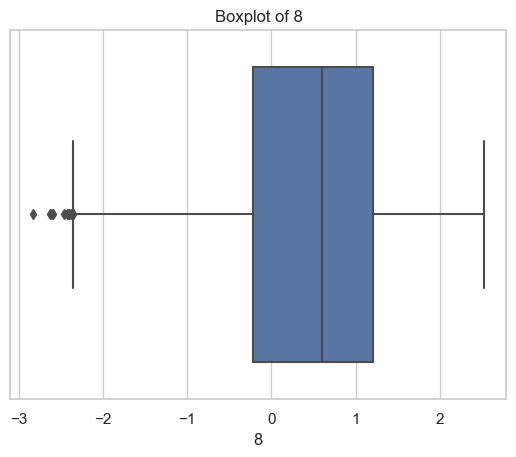

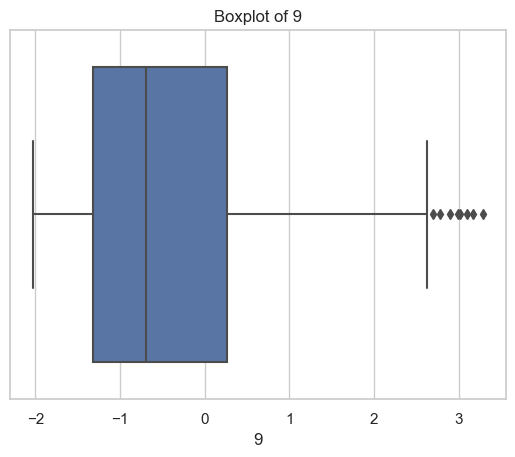

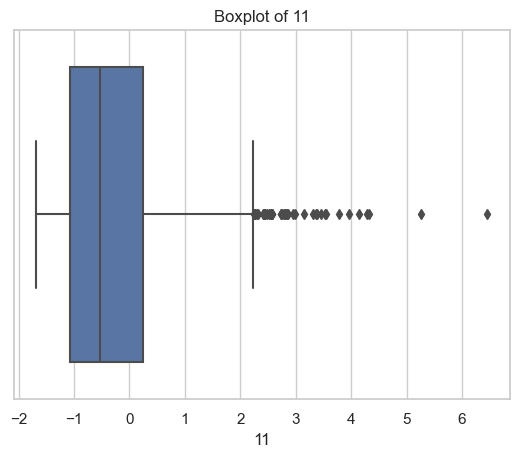

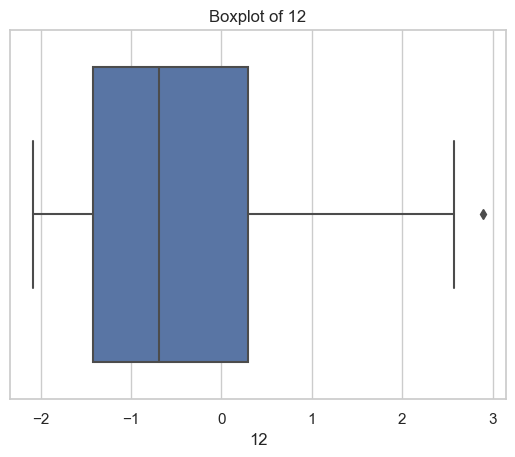

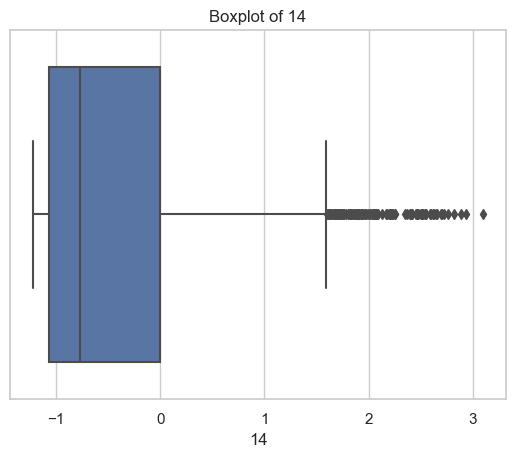

In [8]:
# Calculate the quartiles and IQR for each column
Q1 = df_all.quantile(0.25)
Q3 = df_all.quantile(0.75)
IQR = Q3 - Q1

# Find columns with outlier values
outliers = ((df_all < (Q1 - 1.5 * IQR)) | (df_all > (Q3 + 1.5 * IQR))).any()

# Print the columns with outlier values
print("Columns with outlier values:")
print(outliers[outliers == True].index)

sns.set_theme(style = 'whitegrid')

# Create boxplots for columns with outlier values
for col in outliers[outliers == True].index:
    sns.boxplot(x = df_all[col])
    plt.title(f'Boxplot of {col}')
    plt.show()

Features 0, 6, 8, 9, 11, 12, 14 have outliers

## **Feature Engineering**

### **Preparing the data**

In [9]:
# Split the data to train test

from sklearn.model_selection import train_test_split

X = df_all.drop('label', axis = 1)
y = df_all['label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 0)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((1800, 15), (600, 15), (1800,), (600,))

## **Modeling**

In [10]:
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt


# Extract the features and labels
X = df_all.iloc[:, :-1].values
y = df_all.iloc[:, -1].values

# Define the models to be used
models = {
            'Naive Bayes': GaussianNB(),
            'Decision Tree': DecisionTreeClassifier(random_state = 0),
            'Random Forest': RandomForestClassifier(n_estimators = 100, random_state = 0),
            'Linear Discriminant Analysis': LinearDiscriminantAnalysis(),
            'Quadratic Discriminant Analysis': QuadraticDiscriminantAnalysis(),
            'Multilayer Perceptron': MLPClassifier(hidden_layer_sizes = (100, 100), max_iter = 500, random_state = 0)
         }

# Define the list of feature indices to use
feature_indices = [range(i) for i in range(1, 16)]

# Perform 10-fold cross-validation for each model and feature set
results = {}

for name, model in models.items():
    scores_list = []
    for indices in feature_indices:
        scores = cross_val_score(model, X[:, indices], y, cv = 10)
        scores_list.append(np.mean(scores))
    results[name] = scores_list

In [11]:
# Fetch a dictionary containing best accuracies of all models

best_performance = {}

for k, v in results.items():
    best_performance[k] = max(v)
    
best_performance

{'Naive Bayes': 0.9200000000000002,
 'Decision Tree': 0.9125,
 'Random Forest': 0.9345833333333333,
 'Linear Discriminant Analysis': 0.9254166666666667,
 'Quadratic Discriminant Analysis': 0.9170833333333333,
 'Multilayer Perceptron': 0.9375}

In [13]:
# Best Metrics

best_accuracy = max(best_performance.values())
best_model = max(best_performance, key = best_performance.get)

max_list = max(results.values())
best_no_of_features = max_list.index(best_accuracy) + 1  # because index starts from 0

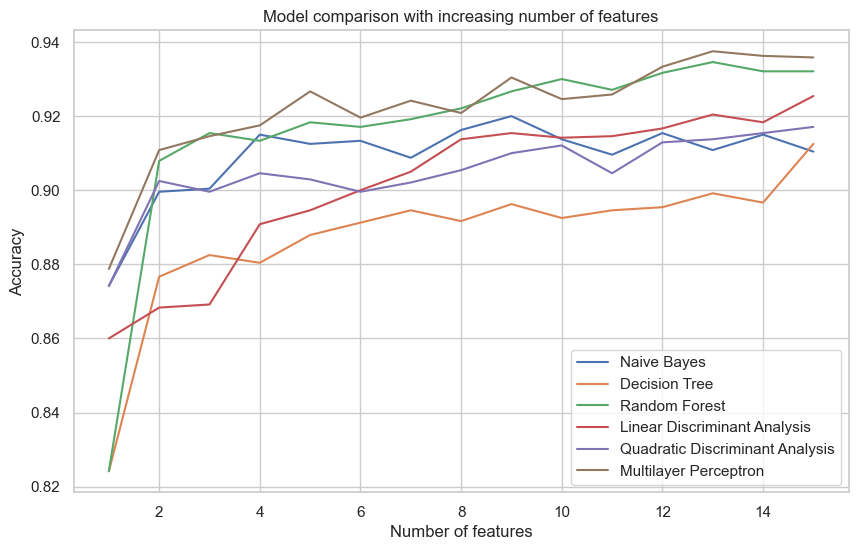

In [14]:
# Plot the results
plt.figure(figsize = (10, 6))
for name, scores in results.items():
    plt.plot(range(1, 16), scores, label = name)
    
plt.xlabel('Number of features')
plt.ylabel('Accuracy')
plt.title('Model comparison with increasing number of features')
plt.legend()

In [15]:
# Retrain the best performance model

model = MLPClassifier(hidden_layer_sizes = (100, 100), max_iter = 500, random_state = 0)
model.fit(X_train, y_train)

MLPClassifier(hidden_layer_sizes=(100, 100), max_iter=500, random_state=0)

Accuracy: 0.9383
Precision: 0.9387
Recall: 0.9383
F1-Score: 0.9384
Class 0 Sensitivity: 0.9073
Class 0 Specificity: 0.9595
Class 0 False Positive Rate: 0.0405
Class 0 False Negative Rate: 0.0927
Class 1 Sensitivity: 0.9545
Class 1 Specificity: 0.9602
Class 1 False Positive Rate: 0.0398
Class 1 False Negative Rate: 0.0455
Class 2 Sensitivity: 0.9543
Class 2 Specificity: 0.9876
Class 2 False Positive Rate: 0.0124
Class 2 False Negative Rate: 0.0457


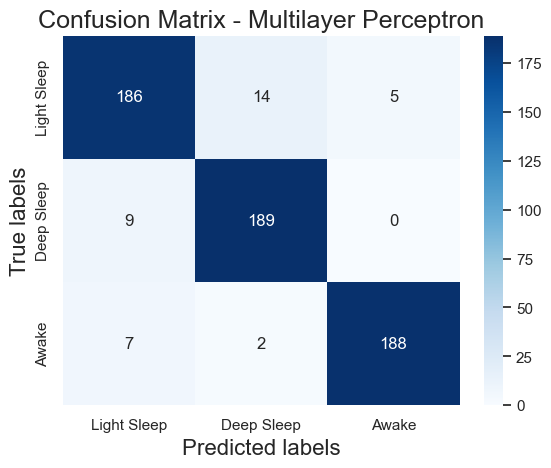

In [16]:
# Model Metrics

# Evaluate the models on the test set using the best number of features

from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, roc_curve, auc, precision_score, recall_score, f1_score

y_pred = model.predict(X_test)

cm = confusion_matrix(y_test, y_pred)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average = "weighted")
recall = recall_score(y_test, y_pred, average = "weighted")
f1 = f1_score(y_test, y_pred, average = "weighted")
sensitivity = recall_score(y_test, y_pred, average = None, zero_division=0)

specificity = {}
false_positive_rate = {}
false_negative_rate = {}

for i in range(len(sensitivity)):
    tn = np.sum(np.delete(np.delete(cm, i, axis = 0), i, axis = 1))
    fp = np.sum(np.delete(cm, i, axis = 0)[:, i])
    fn = np.sum(cm[i, :]) - cm[i, i]
    tp = cm[i, i]
    specificity[i] = tn / (tn + fp)
    false_positive_rate[i] = fp / (tn + fp)
    false_negative_rate[i] = fn / (fn + tp)

test_results = {}

test_results[name] = {
                        "confusion_matrix" : cm,
                        "accuracy" : accuracy,
                        "precision" : precision,
                        "recall": recall,
                        "f1_score" : f1,
                        "sensitivity" : sensitivity,
                        "specificity" : specificity,
                        "false_positive_rate" : false_positive_rate,
                        "false_negative_rate" : false_negative_rate
                    }

sns.heatmap(cm, annot = True, fmt = 'd', cmap = 'Blues', 
            xticklabels=['Light Sleep', 'Deep Sleep', 'Awake'],
            yticklabels=['Light Sleep', 'Deep Sleep', 'Awake'])
plt.xlabel('Predicted labels', fontdict={'fontsize' : 16, 'fontweight' : 18})
plt.ylabel('True labels', fontdict={'fontsize' : 16, 'fontweight' : 18})
plt.title("Confusion Matrix - Multilayer Perceptron", fontdict={'fontsize' : 18, 'fontweight' : 24})

# Print the results
for name, result in test_results.items():
    print(f"Accuracy: {result['accuracy']:.4f}")
    print(f"Precision: {result['precision']:.4f}")
    print(f"Recall: {result['recall']:.4f}")
    print(f"F1-Score: {result['f1_score']:.4f}")
    for i in range(len(result['sensitivity'])):
        print(f"Class {i} Sensitivity: {result['sensitivity'][i]:.4f}")
        print(f"Class {i} Specificity: {result['specificity'][i]:.4f}")
        print(f"Class {i} False Positive Rate: {result['false_positive_rate'][i]:.4f}")
        print(f"Class {i} False Negative Rate: {result['false_negative_rate'][i]:.4f}")